TRIPPy examples
========

Introduction: SExtractor and emcee
--------------------------------

To perform photometry and source subtraction, in addition to having a good PSF (which trippy will generate) one needs three very important parameters: x, y, and m, or source position and amplitude. 

When one has the PSF and TSF already generated, one can run a fitting routine to solve for these. For this purpose, we use [emcee.](https://github.com/dfm/emcee) *emcee* is an MCMC routine which allows for good estimates of (x,y,m) and their uncertainties. We use a likelihood definition as the natural log likelihood of the exponential flux, basically exactly what you'd expect. If you are uncertain of what this means, or care for more detail, please go read the *emcee* documentation.

If the PSF or TSF is not yet known, to get a centroid (x,y), we need to use some other software. We haven't included this inside trippy because there is no point in reinventing a wheel that has already been nearly perfected. For this purpose, we use the venerable [SExtractor.](http://www.astromatic.net/software/sextractor) All jokes on its name aside, *sextractor* does exactly what we need, as well as we would ever need it to be done. 

Trippy includes a module *trippy.scamp* with functions defined in *scamp.py* and *makeParFiles.py* that mearly provide convenient wrappers to call *sextractor*. This has been done in a couple other packages, but not in a way that satisfies me. Hence my own implementation. A couple details to note: makeParFiles creates all the parameter files in the working directory (eg. *makeParFiles.writeConv()*), and scamp is responsible for *sextractor* execution and catalog reading (*scamp.runSex()* and *scamp.getCatalog*). Catalogs are stored in FITS_LDAC format. This choice was done to facilitate execution of the *sextractor* sister program *scamp*, though we won't need to know what that means for full use of trippy. If you are unfamiliar with *sextractor* and its use, don't adopt trippy as a blackbox. [RTFM!](http://www.starlink.rl.ac.uk/docs/sun226.htx/mud165.pdf)

With that out of the way, on to actual business.


The *trippy* tutorial
------------------

The first thing to do is import all the necessary packages. Note that this notebook assumes you have the optional packages installed, as well as SExtractor available on your command line.

**NOTE: proper use of psfStarChooser requires plot interaction. So for this tutorial you'd best comment out the first line, %matplotlib inline. But for my web presentation, I leave inline.**

In [1]:
#%matplotlib inline
import numpy as num, astropy.io.fits as pyf,pylab as pyl
from trippy import psf, pill, psfStarChooser
from trippy import scamp,MCMCfit
import scipy as sci
from os import path
import os
from stsci import numdisplay
from astropy.visualization import interval

The function trim catalog is a convenience function to simply return only those sources that are well enough isolated for PSF generation. It rejects any sources within 30 pixels of another source, any sources with peak pixel above 70,000, and any sources that sextractor has flagged **for what ever reason**. We may fold this into psfStarChooser in the future.


Me: change dist to 20 so that MS4 source can maintain 

In [2]:
def trimCatalog(cat):
    good=[]
    for i in range(len(cat['XWIN_IMAGE'])):
        try:
            a=int(cat['XWIN_IMAGE'][i])
            b=int(cat['YWIN_IMAGE'][i])
            m=num.max(data[b-4:b+5,a-4:a+5])
        except: pass
        dist=num.sort(((cat['XWIN_IMAGE']-cat['XWIN_IMAGE'][i])**2+(cat['YWIN_IMAGE']-cat['YWIN_IMAGE'][i])**2)**0.5)
        d=dist[1]
        if cat['FLAGS'][i]==0 and d>20 and m<70000: #Me: change dist to 20 so that MS4 source can maintain 
            good.append(i)
    good=num.array(good)
    outcat={}
    for i in cat:
        outcat[i]=cat[i][good]
    return outcat


Get the image this tutorial assumes you have. If wget fails then you are likely on a mac, and should just download it manually

In [18]:
inputFile='JPZP_ccd00_1635849p.wcs.fits'
if not path.isfile(inputFile):
    #os.system('wget -O Polonskaya.fits http://www.canfar.phys.uvic.ca/vospace/nodes/fraserw/Polonskaya.fits?view=data')
    print "get the file plz "
else:
    print "We already have the file."

We already have the file.


First load the fits image and get out the header, data, and exposure time.

In [8]:
with pyf.open(inputFile) as han:
    data=han[0].data
    header=han[0].header
    EXPTIME=header['EXPTIME']
    
    
#print(repr(header))  

print (header["JPZP"])

30.0182718483


Next run sextractor on the images, and use trimCatalog to create a trimmed down list of isolated sources. 

makeParFiles handles the creation of all the sextractor files, including the .sex file which we call example.sex, the default.conv, the param file which is saved as def.param.

.runSex creates example.cat which is read by .getCatalog. getCatalog takes as input the catalog name and the parameter file "def.param".

The parameters that are actually used by psfStarChooser and psf.genLookupTable are XWIN_IMAGE, YWIN_IMAGE, FLUX_AUTO, and FLUXERR_AUTO, which are the x,y coordinates, the flux, and the flux uncertainty estimate respectively. The latter two are used in the SNR cut that psfStarChooser makes.

In [9]:
# My notes: TODO I might need to determin input value again (but it seems fine now)
scamp.makeParFiles.writeSex('example_new.sex',
                    minArea=3., #DETECT_MINAREA  
                    threshold=5., # DETECT_THRESH 
                    zpt=header["JPZP"], # MAG_ZEROPOINT  
                    aperture=20., # PHOT_APERTURES 
                    min_radius=2.0, # min_radius is a MAG_AUTO parameter default 3.5 
                          catalogType='FITS_LDAC',
                          saturate=55000) #SATUR_LEVEL level (in ADUs) at which arises saturation 50000

"""Write a modified sextractor file.

Options - paramFileName -the name of the associated parameter
                         file.
          minArea - the minimum threshold area for sources.
                    Default is 20. 
                    ref: 
                    # of pixels above threshold
                    Minimum area of connected pixels in an object.
                    Minimum number of pixels above threshold triggering detection.
          threshold - the snr threshold for sources.
                      default is 8
                      ref: 
                      default.sex is 3.5 
          zpt - the photometric zeropoint.
                default is 27.4. 
                ref: 
                magnitude zero-point default.sex is 27.0.
                There's also a calibration zero-point 

          saturation - the saturation level in adu.
                       default is 40000.
                       ref: 

          aperture - the photometry aperture in pixels
                     default is 11.
                     ref: 
                     default.sex is 5 
"""


scamp.makeParFiles.writeConv()
scamp.makeParFiles.writeParam(numAps=1) #numAps is thenumber of apertures that you want to use. Here we use 1

scamp.runSex('example_new.sex', inputFile ,options={'CATALOG_NAME':'example_new.cat'},verbose=False)
catalog=trimCatalog(scamp.getCatalog('example_new.cat',paramFile='def.param'))


Finally, find the source closest to 811, 4005 which is the bright asteroid, 2006 Polonskaya. Also, set the rate and angle of motion. These were found from JPL horizons. The 1 degree increase is to account for the slight rotation of the image.

Note: in this image, the asteroid is near (4005,811) and we apply a distance sort to the catalog to find correct catalog entry, and the source centroid, which we store in (xt,yt).

Setting the important asteroid parameters. xt,yt contain the location of the asteroid itself (near 811,4005), rate and angle are the rate and angle of traililng, in "/hr and degrees. We find the actual centroid as the location closest to that point.


My notes: RA 18:20:10.8 DEC -7:40:45 from my earlier notes. From DS9 get X 1961 Y 3557 

In [10]:
dist=((catalog['XWIN_IMAGE']-1961)**2+(catalog['YWIN_IMAGE']-3557)**2)**0.5
args=num.argsort(dist)
xt=catalog['XWIN_IMAGE'][args][0]
yt=catalog['YWIN_IMAGE'][args][0]

flag = catalog['FLAGS'][args][0]

# TODO: some randome rate might not right 
rate=2.74 # "/hr (sky motion value for MS4 at the hour of observing)
angle=176.9 # degrees counter clockwise from horizontal, right  (might be wrong this looks suspitious)

print(xt)
print(yt)


1961.6070133653875
3558.1350105552137


Now use psfStarChooser to select the PSF stars. The first and second parameters to starChooser are the fitting box width in pixels, and the SNR minimum required for a star to be considered as a potential PSF star. 

Optional but important inputs are autoTrim and noVisualSelection. The former, when True, uses bgFinder.fraserMode to attempt to determine what FWHM corresponds to actual stars, and rejects all sources with FWHM outside +-0.5 pixels of the modal value. noVisualSelection determines if manual input is required. When set to false, all stars are considered. **Until you know the software, I suggest you use noVisualSelection=True for manual selection, and autoTrim=False to see all sources in the plot window.**

For each star provided to psfStarChooser, it will print a line to screen of x,y and best fit alpha, beta, and FWHM of the moffat profile fit.

Then psfStarChooser will pop-up a multipanel window. **Top left:** histogram of fit chi values. **Top right:** chi vs. FWHM for each fitted source. **Middle right:** histogram of FWHM. **Bottom right:** image display of the currently selected source. **Bottom left:** Radial profiles of all sources displayed in the top right scatter plot.

The point of this window is to select only good stars for PSF generation, done by zooming to the good sources, and rejecting those that are bad.

Use the zoom tool to select the region containing the stars. In this image, that's a cluser at FWHM~3.5 pixels.

Left and right clicks will select a source, now surrounded by a diamond, displaying the radial profile bottom left, and the actual image bottom right.

Right click will oscillate between accepted source and rejected source (blue and red respectively). 

When the window is closed, only those sources shown as blue points, and within the zoom of the top right plot will be used to generate the PSF.

The array goodFits is returned for convenience and contains the moffat fit details of each accepted source. Each entry is [FWHM, chi, alpha, beta, x, y, local background value].

The array goodMeds is just the median of goodFits, and provides the median moffat alpha and beta of the selected stars.

Fitting stars with moffat profiles...
      X         Y    chi    a     b    FWHM
    1312.14    50.83 1.23  3.89  2.62  4.29 
    1415.66    77.27 0.51  3.61  2.34  4.25 
     442.35    88.81 1.12  3.78  2.49  4.29 
     855.28   150.48 0.33  3.38  2.11  4.22 
    1586.98   151.51 1.36  4.25  2.96  4.37 
    1641.56   179.49 0.29  3.62  2.30  4.30 
     530.86   210.59 0.32  3.69  2.40  4.27 
     117.69   211.91 0.29  3.65  2.35  4.28 
     735.27   207.06 0.42  3.76  2.45  4.31 
    1076.31   221.33 0.53  3.76  2.50  4.25 
    1607.23   301.27 0.25  3.73  2.43  4.29 
    1458.43   263.57 0.43  3.83  2.55  4.28 
    1709.97   316.25 0.26  3.78  2.47  4.31 
    1248.75   296.90 0.26  2.72  1.53  4.13 


/Users/janepeng/Applications/anaconda2/envs/geminiconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 250.
  warnings.warn(errors[info][0], RuntimeWarning)


     452.03   382.15 188.23  16.87  19.79  6.38 
     558.74   317.41 1.76  3.65  2.35  4.28 
     841.09   312.47 1.19  3.39  2.13  4.21 
     351.73   311.47 0.42  3.49  2.20  4.25 
     102.48   314.99 0.75  3.73  2.44  4.29 
     305.12   327.47 0.58  3.81  2.47  4.35 
     823.91   342.49 5.16  3.75  2.45  4.29 
     229.83   470.75 0.27  3.76  2.42  4.33 
     603.68   445.38 0.44  3.80  2.51  4.30 
     206.28   599.60 307.69  18.93  22.90  6.64 
    1668.51   525.00 0.01  1.69  1.00  3.39 
    1981.79   576.98 0.34  3.48  2.18  4.26 
    1294.20   562.43 1.62  4.02  2.71  4.35 
     506.32   593.76 0.28  3.68  2.38  4.28 
    1930.05   634.32 0.27  3.75  2.47  4.27 
    1076.41   608.98 0.56  3.75  2.47  4.27 
    1473.23   640.36 0.43  3.58  2.32  4.23 
    1538.90   716.59 0.30  3.66  2.41  4.23 
     963.96   742.94 3.85  4.49  2.66  4.90 
     410.37   800.18 2.18  3.59  2.31  4.25 
    1401.17   815.02 0.35  3.61  2.36  4.22 
    1972.36   829.23 0.11  1.83  1.10  3.43 
  

<IPython.core.display.Javascript object>


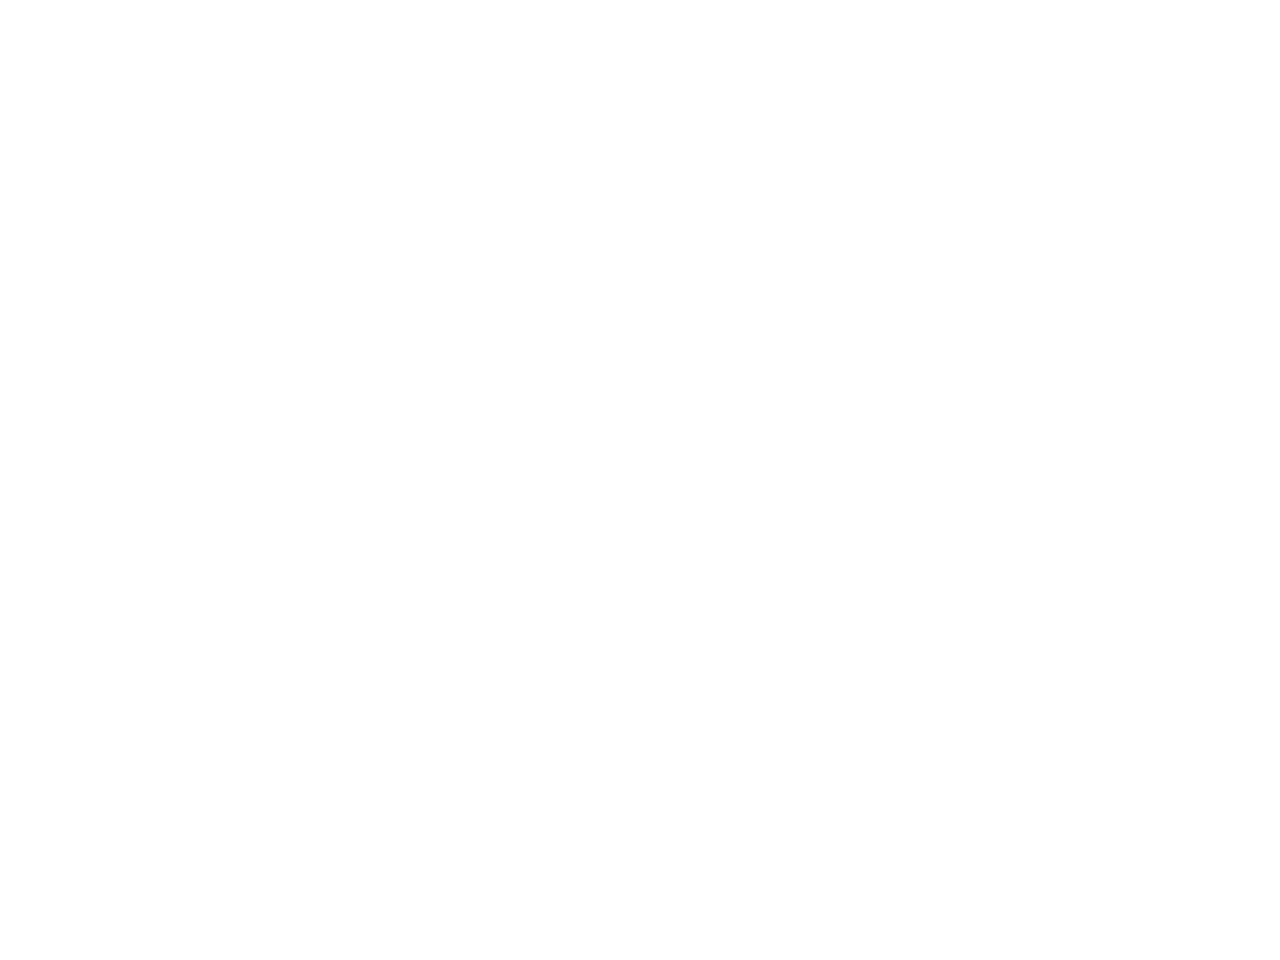

[[4.29000000e+00 7.29994716e+01 3.89425305e+00 ... 1.31214386e+03
  5.08274855e+01 1.44000000e+02]
 [4.25000000e+00 4.94293102e+01 3.61297906e+00 ... 1.41566139e+03
  7.72671293e+01 1.44000000e+02]
 [4.29000000e+00 3.51758971e+01 3.78108403e+00 ... 4.42346246e+02
  8.88113251e+01 1.44000000e+02]
 ...
 [4.45000000e+00 3.97957608e+01 4.19762825e+00 ... 2.07974234e+02
  3.99087876e+03 1.54000000e+02]
 [4.38000000e+00 3.48526801e+01 3.90920294e+00 ... 5.39526827e+02
  4.56211408e+03 1.48919377e+02]
 [4.37000000e+00 1.03707834e+02 3.83190041e+00 ... 1.46815593e+03
  3.83167532e+03 1.45000000e+02]]
[   4.27         61.21439091    3.69703155    2.41481499 1083.7140918
   83.03922721  144.        ]
end print


In [11]:
%matplotlib notebook
%matplotlib notebook

starChooser=psfStarChooser.starChooser(data,
                                        catalog['XWIN_IMAGE'],catalog['YWIN_IMAGE'],
                                        catalog['FLUX_AUTO'],catalog['FLUXERR_AUTO'])
(goodFits,goodMeds,goodSTDs)=starChooser(30,200,noVisualSelection=False,autoTrim=False)

print goodFits
print goodMeds
print "end print"

Generate the PSF. We want a 61 pixel wide PSF, adopt a repFactor of 10, and use the mean star fits chosen above.

**always use odd values for the dimensions. Even values (eg. 60 instead of 61) result in off centered lookup tables.**

Repfactors of 5 and 10 have been tested thoroughly. Larger is pointless, smaller is inaccurate. 5 is faster than 10, 10 is more accurate than 5.

The PSF has to be wide/tall enough to handle the trailing length and the seeing disk. For Polonskaya, the larger is trailing, at ~19"/hr*480s/3600/0.185"/pix = 14 pixels. Choose something a few times larger. Also, stick with odd width PSFs, as the even ones have some funny centroid stuff that I haven't fully sorted out.

The full PSF is created with instantiation, and running both genLookupTable and genPSF.

Full width at half maximum 4.270 (in pix).


<IPython.core.display.Javascript object>


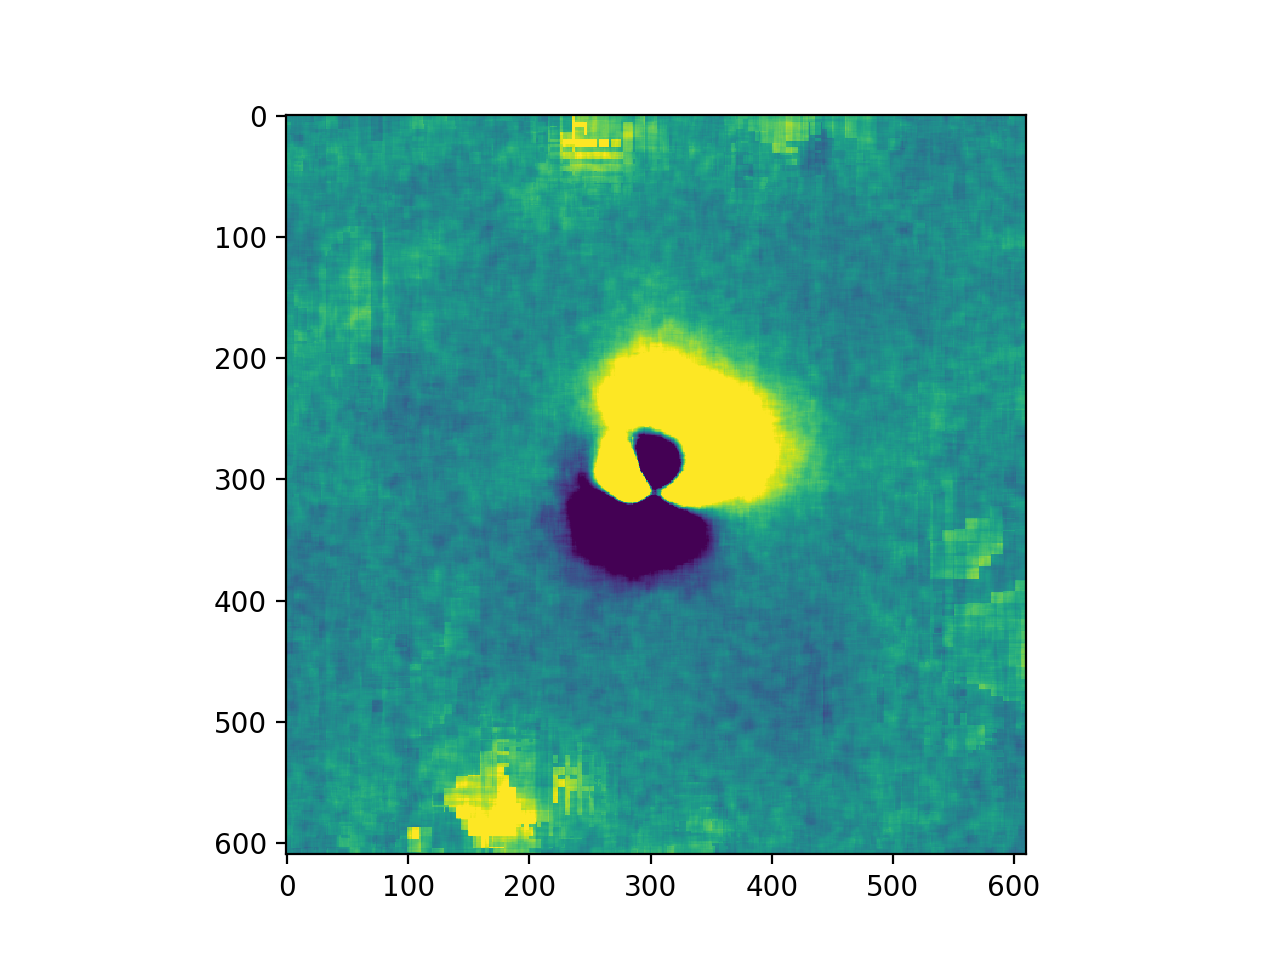

In [12]:
goodPSF=psf.modelPSF(num.arange(61),num.arange(61), alpha=goodMeds[2],beta=goodMeds[3],repFact=10)
fwhm=goodPSF.FWHM() ###this is the pure moffat FWHM. Can also get this value by passing option fromMoffatProfile=True
goodPSF.genLookupTable(data,goodFits[:,4],goodFits[:,5],verbose=False)
fwhm=goodPSF.FWHM() ###this is the FWHM with lookuptable included
fwhm=goodPSF.FWHM(fromMoffatProfile=True) ###this is the pure moffat FWHM.

print "Full width at half maximum {:5.3f} (in pix).".format(fwhm)

(z1,z2)=numdisplay.zscale.zscale(goodPSF.lookupTable)
normer=interval.ManualInterval(z1,z2)
pyl.imshow(normer(goodPSF.lookupTable))
pyl.show()

Now generate the TSF, which we call the line/long PSF interchangeably through the code...

Rate is in units of length/time and pixScale is in units of length/pixel, time and length are in units of your choice. Sanity suggests arcseconds and hours. Then rate in "/hr and pixScale in "/pix. Angle is in degrees counter clockwise from horizontal between +-90 degrees.

**This can be rerun to create a TSF with different rate/angle of motion, though keep in mind that the psf class only contains one longPSF (one rate/angle) at any given time.**

In [13]:
goodPSF.line(rate,angle,EXPTIME/3600.,pixScale=0.185,useLookupTable=True)

Using the lookup table when generating the long PSF.


Now calculate aperture corrections for the PSF and TSF. Store for values of r=1.4*FWHM.

Note that the precision of the aperture correction depends lightly on the sampling from the compute functions. 10 is generally enough to preserve 1% precision in the .roundAperCorr() and lineAperCorr() functions which use linear interpolation to get the value one actually desires.

**NOTE: Set useLookupTable=False if one wants to calculate from the moffat profile alone. Generally, not accuarate for small apertures however.**

In [14]:
goodPSF.computeRoundAperCorrFromPSF(psf.extent(0.8*fwhm,4*fwhm,10),display=False,
                                                          displayAperture=False,
                                                          useLookupTable=True)
roundAperCorr=goodPSF.roundAperCorr(1.4*fwhm)

goodPSF.computeLineAperCorrFromTSF(psf.extent(0.1*fwhm,4*fwhm,10),
                                                         l=(EXPTIME/3600.)*rate/0.185,a=angle,display=False,displayAperture=False)
lineAperCorr=goodPSF.lineAperCorr(1.4*fwhm)
print lineAperCorr,roundAperCorr

/Users/janepeng/Dropbox/Trippy_workDir/trippy/trippy/trippy_utils.py:62: RuntimeWarning: invalid value encountered in double_scalars
  self.m=(p2[1]-p1[1])/(p2[0]-p1[0])
/Users/janepeng/Dropbox/Trippy_workDir/trippy/trippy/trippy_utils.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  self.m=(p2[1]-p1[1])/(p2[0]-p1[0])


    Radius  Flux      Magnitude
      0.43   4718.985    -9.185
      0.64   9152.188    -9.904
      0.97  18312.571   -10.657
      1.46  35726.873   -11.382
      2.20  64457.513   -12.023
      3.31 102790.936   -12.530
      4.99 137901.444   -12.849
      7.52 161366.377   -13.020
     11.34 174427.727   -13.104
     17.08 180058.690   -13.139
0.22327798766981388 0.17858002589107258


Store the PSF.

In [15]:
goodPSF.psfStore('psf_new.fits')


We could save most of the above by restoring a previously constructed PSF by the following commented out code.

In [12]:
#goodPSF=psf.modelPSF(restore='psf_new.fits')


And we could generate a new line psf by recalling .line with a new rate and angle

In [13]:
#goodPSF.line(new_rate,new_angle,EXPTIME/3600.,pixScale=0.185,useLookupTable=True)

Now let's do some pill aperture photometry. Instantiate the class, then call the object you created to get photometry of Polonskaya. Again assume repFact=10.

pillPhot takes as input the same coordinates as outputted by sextractor.

First example is of a round star which I have manually taken the coordinates from above. Second example is for the asteroid itself.

enableBGselection=True will cause a popup display of the source, in which one can zoom to a section with no background source.

The detault background selection technique is "smart". See bgFinder documentation for what that means. If you want to change this away from 'fraserMode', take a look at the options in bgFinder.

display=True to see the image subsection

r is the radius of the pill, l is the length, a is the angle. Sky radius is the radius of a larger pill aperture. The pixels in this larger aperture, but outside the smaller aperture are ignored. Anything outside the larger pill, but inside +-width is used for background estimation.

Trimbghighpix is mostly made not important if mode=smart. But if you want to use a mean or median for some reason, then this value is used to reject pixels with values trimBGhighPix standard deviations above the mean of the cutout.

<IPython.core.display.Javascript object>


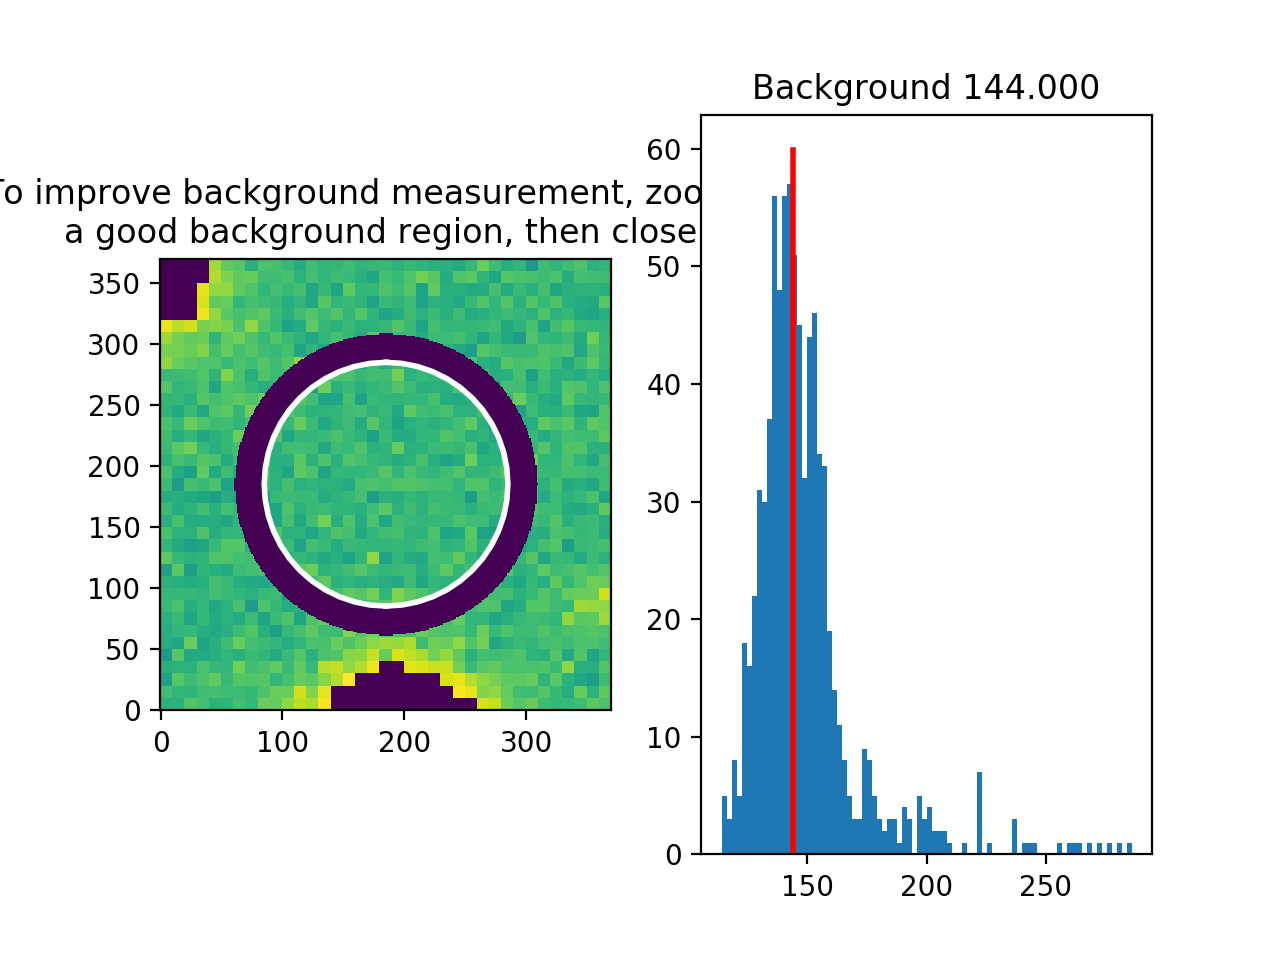

Current background value: 144.000


/Users/janepeng/Applications/anaconda2/envs/geminiconda/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/janepeng/Dropbox/Trippy_workDir/trippy/trippy/pill.py:301: RuntimeWarning: invalid value encountered in log10
  self.magnitude = zpt-2.5*num.log10(self.sourceFlux/self.exptime)


In [16]:

#initiate the pillPhot object
phot=pill.pillPhot(data,repFact=10)
#get photometry, assume ZPT=26.0
#enableBGselection=True allows you to zoom in on a good background region in the aperture display window
#trimBGhighPix is a sigma cut to get rid of the cosmic rays. They get marked as blue in the display window
#background is selected inside the box and outside the skyRadius value
#mode is th background mode selection. Options are median, mean, histMode (JJ's jjkmode technique), fraserMode (ask me about it), gaussFit, and "smart". Smart does a gaussian fit first, and if the gaussian fit value is discrepant compared to the expectation from the background std, it resorts to the fraserMode. "smart" seems quite robust to nearby bright sources

#examples of round sources (me: I messed up... )
phot(goodFits[0][1], goodFits[0][1],radius=9.09*1.1,l=0.0,a=0.0,
             skyRadius=4*3.09,width=6*3.09,
              zpt=26.0,exptime=EXPTIME,enableBGSelection=True,display=True,
              backupMode="fraserMode",trimBGHighPix=3.)

In [15]:
#example of a trailed source
phot(xt,yt,radius=fwhm*1.4,l=(EXPTIME/3600.)*rate/0.185,a=angle,
             skyRadius=4*fwhm,width=6*fwhm,
              zpt=26.0,exptime=EXPTIME,enableBGSelection=True,display=True,
              backupMode="smart",trimBGHighPix=3.)

Current background value: 140.300


The SNR function calculates the SNR of the aperture,as well as provide an estiamte of the magnitude/flux uncertainties. Select useBGstd=True if you wish to use the background noise level instead of sqrt of the background level in your uncertainty estimate. **Note: currently, this uncertainty estimate is approximate, good to a few percent. Future improvements will be made to get this a bit more accurate.**

verbose=True puts some nice terminal output in your face. These values can be accessed with their internal names.

In [16]:
phot.SNR(verbose=True)

#get those values
print phot.magnitude
print phot.dmagnitude
print phot.sourceFlux
print phot.snr
print phot.bg



   SNR: 61.11471960785164
   Flux: 7507.6186385817655
   Background: 140.30020213701096
   Background STD: 10.403719835598421
   Num Pixels : 115.56

20.445216338718744
0.017765543419406293
7507.6186385817655
61.11471960785164
140.30020213701096


Let's get aperture corrections measured directly from  a star.

<IPython.core.display.Javascript object>


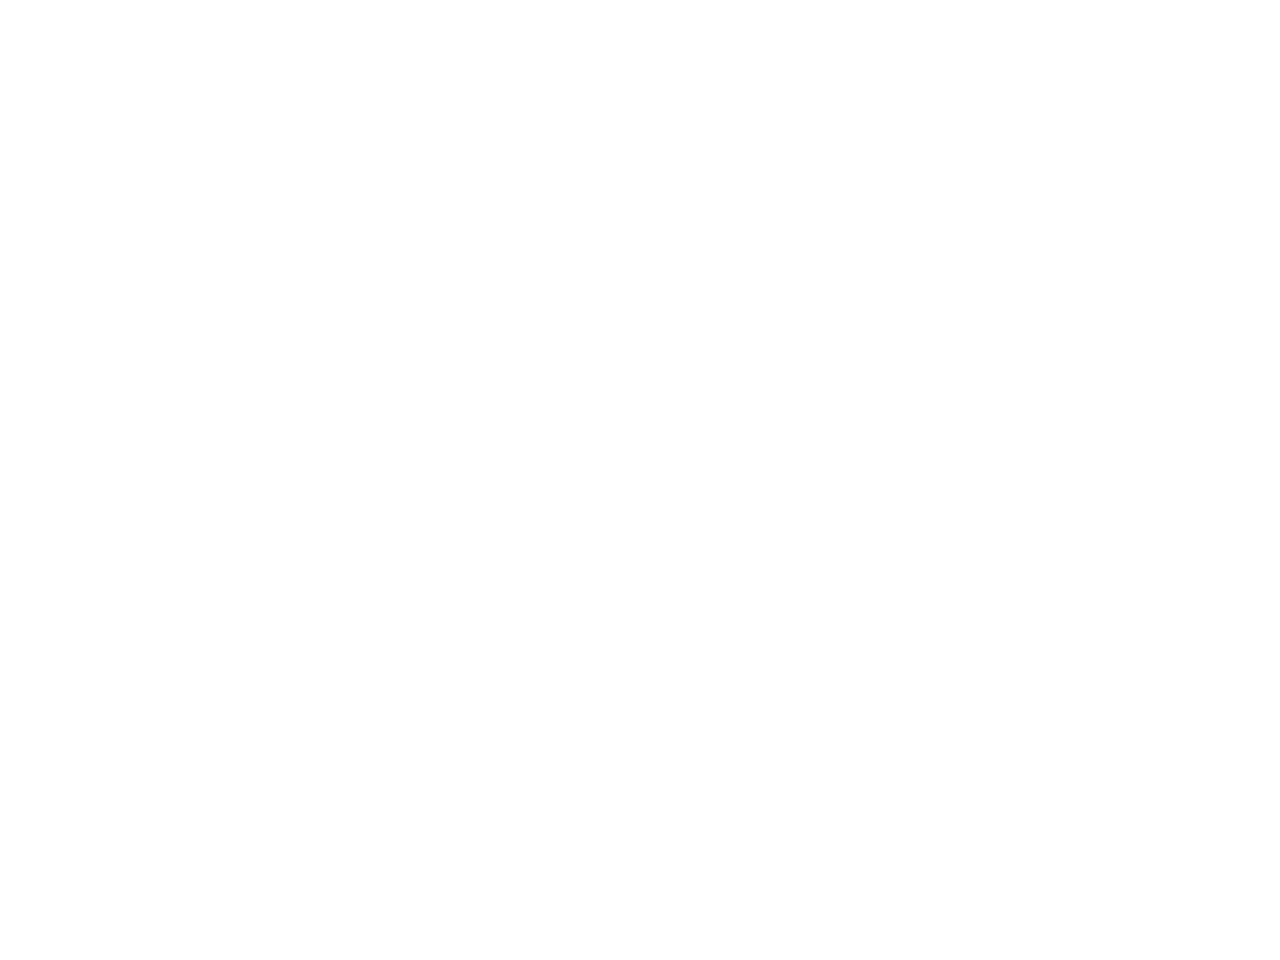

0.1854899418129321


In [17]:
phot.computeRoundAperCorrFromSource(goodFits[0,4],goodFits[0,5],num.linspace(1*fwhm,4*fwhm,10),
                                    skyRadius=5*fwhm, width=6*fwhm,displayAperture=False,display=True)
print phot.roundAperCorr(1.4*fwhm)

Finally, let's do some PSF source subtraction. This is only possible with emcee and sextractor installed.

First get the cutout. This makes everything faster later. Also, remove the background, just because.

In [18]:
Data=data[int(yt)-200:int(yt)+200,int(xt)-200:int(xt)+200]-phot.bg

Now instantiate the MCMCfitter class, and then perform the fit. Verbose=False will not put anything to terminal. Setting to true will dump the result of each step. Only good idea if you insist on seeing what's happening. Do you trust black boxes?

Set useLinePSF to True if you are fitting a trailed source, False if a point source. 

Set useErrorMap to True if you care to use an estimate of the poisson noise in each pixel during your fit. This produces honest confidence ranges.

I personally like nWalkers=nBurn=nStep=40. To get a reasonable fit however, that's overkill. But to get the best... your mileage will vary.

**This will take a while on a computer. ~1 minute on a modern i5 processor, much longer if you computer is a few years old. You can reduce the number of walkers, nBurn and nStep to ~10 each if you are impatient. This will drop the run time by ~4x**

In [19]:
fitter=MCMCfit.MCMCfitter(goodPSF,Data)
fitter.fitWithModelPSF(200+xt-int(xt)-1,200+yt-int(yt)-1, m_in=1000.,
                       fitWidth=10, 
                       nWalkers=20, nBurn=20, nStep=20, 
                       bg=phot.bg, useLinePSF=True, verbose=False,useErrorMap=False)


Initializing sampler
Executing xy burn-in... this may take a while.
Executing xy production run... this will also take a while.
Best point: [ 1.99792301e+02  1.99136433e+02 -1.85085420e+10]
Executing amplitude burn-in... this may take a while.
Executing amplitude production run... this will also take a while.
Best point: [ 3.79532895e+00 -5.23002930e+04]
Executing xy-amp burn-in... this may take a while.


/Users/janepeng/Applications/anaconda2/envs/geminiconda/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/janepeng/Applications/anaconda2/envs/geminiconda/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Executing xy-amp production run... this will also take a while.


Now get the fits results, including best fit and confidence region using the input value. 0.67 for 1-sigma is shown

In [20]:
(fitPars,fitRange)=fitter.fitResults(0.67)
print fitPars
print fitRange

Best point: [ 1.99567820e+02  1.99166670e+02  4.78076731e+00 -3.20025547e+04]
[ 1.99567820e+02  1.99166670e+02  4.78076731e+00 -3.20025547e+04]
[[199.58696069242103, 199.86348094546497], [199.1241178068244, 199.30341059297285], [-215.30621166185506, 12.529814195967678]]


Finally, lets produce the model best fit image, and perform a subtraction. Plant will plant a fake source with the given input x,y,amplitude into the input data. If returnModel=True, then no source is planted, but the model image that would have been planted is returned.

remove will do the opposite of plant given input data (it actually just calls plant). 

In [21]:
modelImage=goodPSF.plant(fitPars[0],fitPars[1],fitPars[2],Data,addNoise=False,useLinePSF=True,returnModel=True)
pyl.imshow(modelImage)
pyl.show()


Now show the image and the image with model removed for comparison. This also provides an example of how to use stsci.numdisplay and astropy.visualization to display an astronomy image using the zscale scaling.

In [22]:
removed=goodPSF.remove(fitPars[0],fitPars[1],fitPars[2],Data,useLinePSF=True)

(z1,z2)=numdisplay.zscale.zscale(removed)
normer=interval.ManualInterval(z1,z2)

pyl.imshow(normer(Data))
pyl.show()

pyl.imshow(normer(removed))
pyl.show()